## Error Analysis

#### Config

In [ ]:
## packages
import matplotlib.pyplot as plt
import opensimplex
import numpy as np
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })

## toolkit
from src.triangulations import tri_rectangle
from src.fem import build_matricies, solve_fem, u_func

## config
save = True
tmax = 100
dt = 0.01
L = 10
opensimplex.seed(0)

#### PDE

In [2]:
## pde config
N = 2
gamma = np.array([1, 0.02])
k1 = 9
k2 = 11
r = lambda u: np.column_stack((
        k1 * (u[:, 1] - u[:, 0] * u[:, 1] / (1 + u[:, 1]**2)),
        k2 - u[:, 1] - 4 * u[:, 0] * u[:, 1] / (1 + u[:, 1]**2),
    ))

#### Solve It

0
1
2


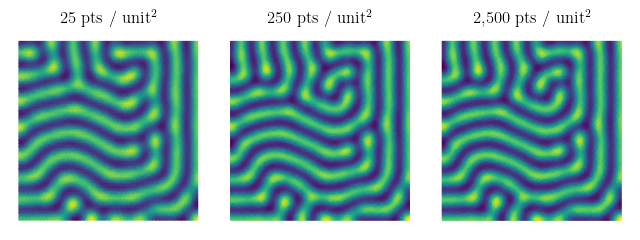

In [ ]:
## ns we work with
triNs = [5, 16, 25]

## plot setup
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(6.5)
fig.set_figheight(2.5)
for ax in axs:
    ax.set_axis_off()
    ax.axis('equal')

for i, triN in enumerate(triNs):
    ## triangulate the domain
    pts, tris = tri_rectangle(L, L, triN)
    damp_mat, stiff_mat = build_matricies(pts, tris)

    ## intial condition
    opensimplex.seed(0)
    u = np.array([opensimplex.noise2(x, y) for x, y in pts])
    opensimplex.seed(10)
    v = np.array([opensimplex.noise2(x, y) for x, y in pts])
    u0 = np.array((u, v)).T

    ## solve the system
    u = solve_fem(r, gamma, tmax, dt, u0, damp_mat, stiff_mat)[-1]

    ## plot it
    axs[i].set_title(f'{25 * 10**i:,} pts $/$ unit$^2$')
    axs[i].tripcolor(
            pts[:, 0],
            pts[:, 1],
            u[:, 0],
            triangles=tris,
            shading='gouraud',
        )

## final things
fig.tight_layout()
if save: fig.savefig('paper/figures/error.pdf', bbox_inches='tight')

## memory
del pts, tris, stiff_mat, damp_mat, u0, u, fig, axs

#### Error Plot

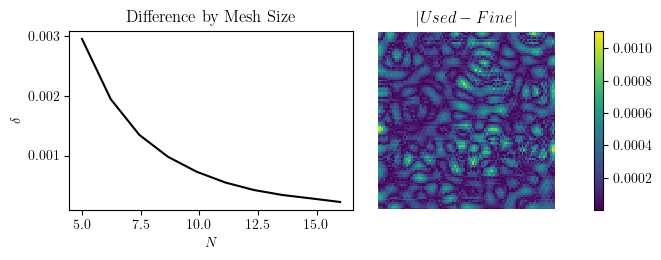

In [3]:
## ns we work with
n_gps = 100
big_triN = 25  # "base" triN
triNs = np.linspace(5, 16, 10)
x, y = np.linspace(0, L, n_gps), np.linspace(0, L, n_gps)
x, y = np.meshgrid(x, y)

## get u(x, y)
def eval_uxy(triN):
    ## triangulate the domain
    pts, tris = tri_rectangle(L, L, triN)
    damp_mat, stiff_mat = build_matricies(pts, tris)

    ## intial condition
    opensimplex.seed(0)
    u = np.array([opensimplex.noise2(x, y) for x, y in pts])
    opensimplex.seed(10)
    v = np.array([opensimplex.noise2(x, y) for x, y in pts])
    u0 = np.array((u, v)).T

    ## solve the system
    u = solve_fem(r, gamma, tmax, dt, u0, damp_mat, stiff_mat)[-1]

    ## get at x, y
    uxy = u_func(x, y, pts, tris, u[:, 0])

    return uxy

## calculate baseline
big_uxy = eval_uxy(big_triN)

## loop over each N, get the value there
ints = []
for triN in triNs:
    # calaute it
    uxy = eval_uxy(triN)

    # integral
    ints.append(np.abs(big_uxy - uxy).sum() / uxy.size)

## plot it
# plot setup
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(6.5)
fig.set_figheight(2.4)

# integrals over N
axs[0].set_title('Difference by Mesh Size')
axs[0].set_ylabel(r'$\delta$')
axs[0].set_xlabel('$N$')
axs[0].plot(triNs, ints, 'k-')

# last difference
axs[1].set_title('$|Used - Fine|$')
axs[1].set_axis_off()
axs[1].axis('equal')
cb = axs[1].pcolormesh(x, y, np.abs(big_uxy - uxy))
fig.colorbar(cb)

# final things
fig.tight_layout(pad=0)
if save: fig.savefig('paper/figures/err_ovr_N.pdf', bbox_inches='tight')